# Trénovanie modelu na základe DST indexu 1h dopredu 6h dozadu

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

2024-04-28 10:18:18.808054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
            'DST']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST'

y_col='DST'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()
y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

In [3]:
n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [5]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2024-04-28 10:18:31.810394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
# callbacks
saved_model = "model_6_1.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [7]:
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1139/1139 [==============================] - ETA: 0s - loss: 97.4621 - mae: 4.8794
Epoch 1: val_mae improved from inf to 3.67519, saving model to 6_dozadu_1_dopredu.hdf5
1139/1139 [==============================] - 65s 53ms/step - loss: 97.4621 - mae: 4.8794 - val_loss: 61.4425 - val_mae: 3.6752
Epoch 2/20
1138/1139 [============================>.] - ETA: 0s - loss: 43.1443 - mae: 3.7257
Epoch 2: val_mae improved from 3.67519 to 3.58737, saving model to 6_dozadu_1_dopredu.hdf5
1139/1139 [==============================] - 57s 50ms/step - loss: 43.1183 - mae: 3.7249 - val_loss: 50.4726 - val_mae: 3.5874
Epoch 3/20
1138/1139 [============================>.] - ETA: 0s - loss: 43.0018 - mae: 3.6196
Epoch 3: val_mae improved from 3.58737 to 3.42624, saving model to 6_dozadu_1_dopredu.hdf5
1139/1139 [==============================] - 57s 50ms/step - loss: 42.9891 - mae: 3.6198 - val_loss: 44.2814 - val_mae: 3.4262
Epoch 4/20
1139/1139 [==============================] - ETA: 0s - lo

In [8]:
# prediction
y_pred = model.predict(test_generator)

610/610 [==============================] - 12s 18ms/step


Confusion matrix: 
[[124295   1118]
 [  5413  25284]]


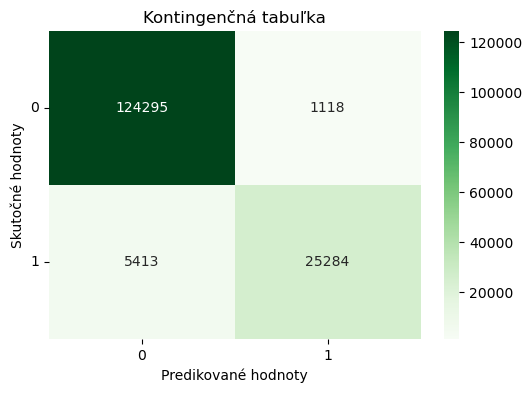

In [9]:
y_pred2 = np.where(y_pred <= -20, 1, 0)
y_test2 = np.where(y_test[n_input:] <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title('Kontingenčná tabuľka')
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'])
plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], rotation=0)
plt.show()

In [10]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    125413
           1       0.96      0.82      0.89     30697

    accuracy                           0.96    156110
   macro avg       0.96      0.91      0.93    156110
weighted avg       0.96      0.96      0.96    156110



In [11]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [12]:
df.describe()

,y_true,y_predict
count,156110.000000,156110.000000
mean,-9.785055,-9.474780
std,16.323784,14.564303
min,-374.000000,-352.396698
25%,-16.000000,-15.846547
50%,-7.000000,-7.406036
75%,0.000000,-0.778961
max,77.000000,49.285034


<AxesSubplot:>

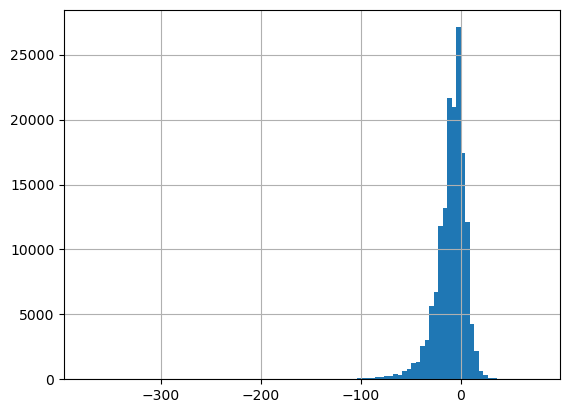

In [13]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

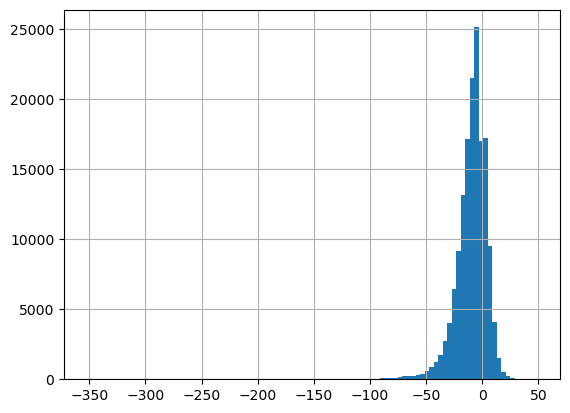

In [14]:
df["y_predict"].hist(bins=100)

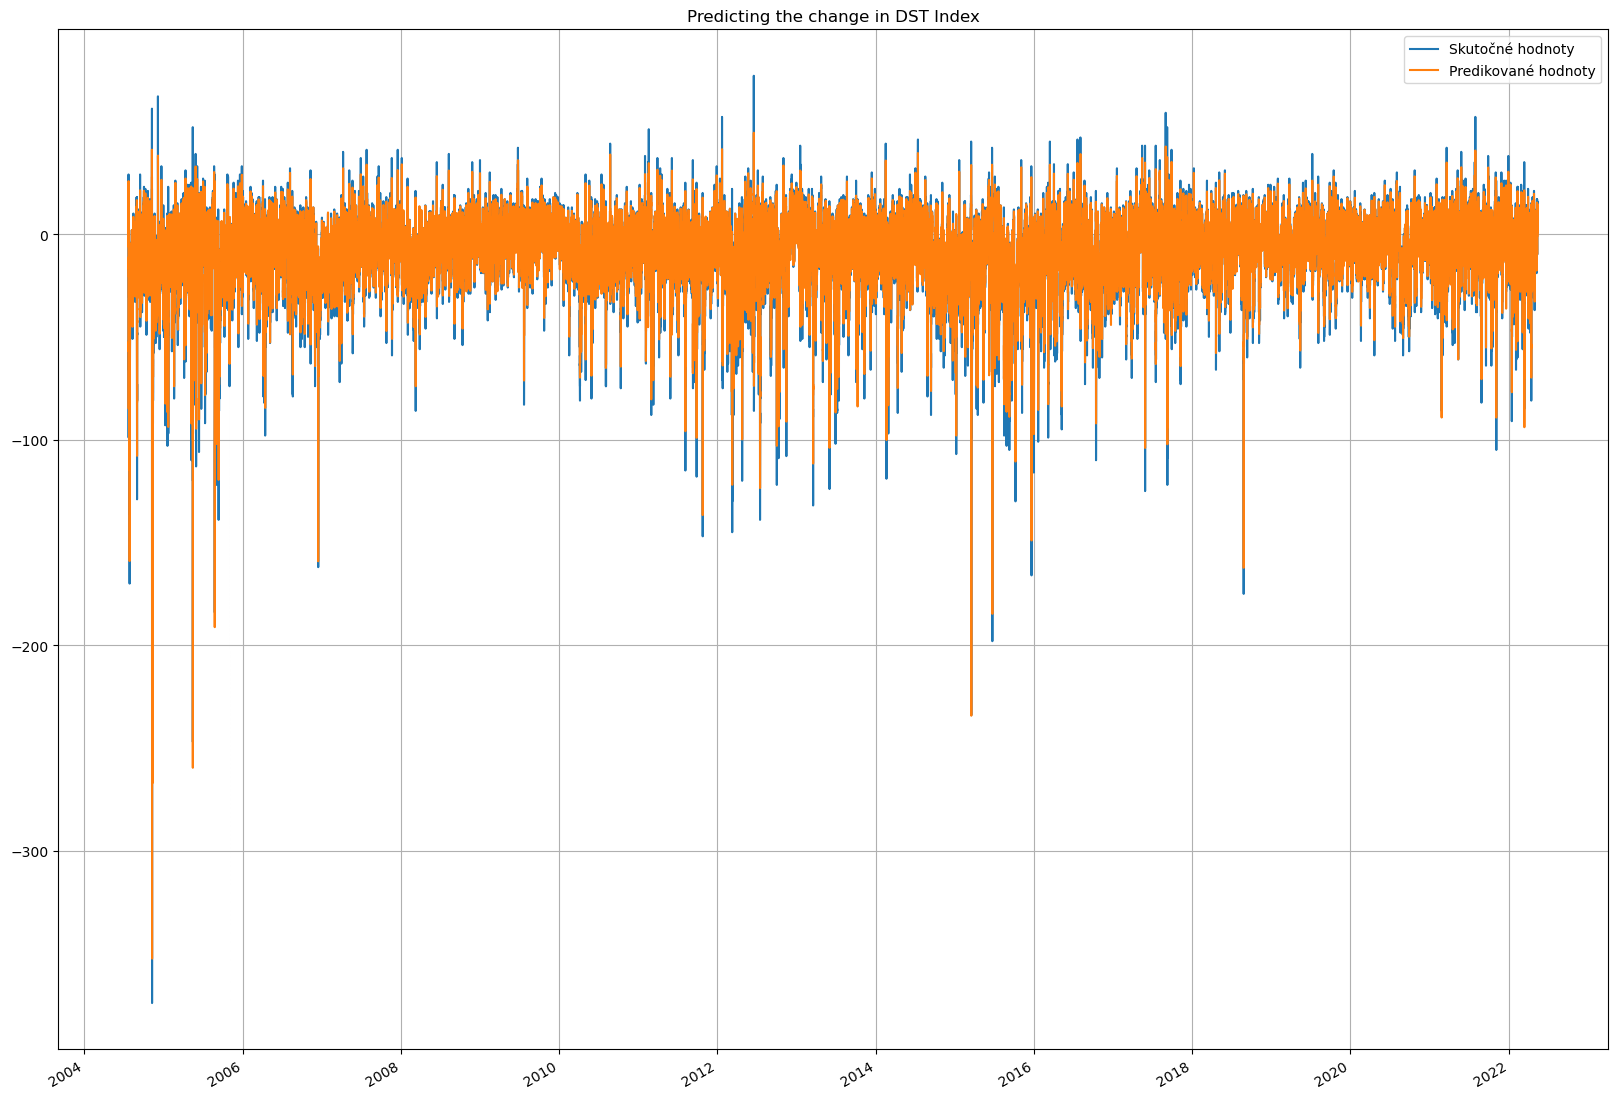

In [15]:
plt.figure(figsize=(20, 15))
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [16]:
df.to_csv('predikcie_6h_dozadu_1h_dopredu.csv')

# Vysvetliteľnosť modelu na základe DST indexu 1h dopredu 6 dozadu

In [17]:
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

In [18]:
#hodnota pre vypínanie intervalov priemer
value_for_shutdown = np.mean(X_test)
value_for_shutdown

-9.784205334494862

In [19]:
#hodnota pre vypínanie intervalov median
value_for_shutdown_median = np.median(X_test)
value_for_shutdown_median

-7.0

In [20]:
def XAI_for_DST_Prediction(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(-5,1)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig

In [21]:
def XAI_for_DST_Prediction_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]
    # audio_scaled1 = np.repeat(audio_scaled,interval_length)
    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    dst_new = np.append(dst_new,y_pred_single)
    
    
    time_data = np.arange(-6,2)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+2],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+2, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6]+1, color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

1/1 [==============================] - 0s 56ms/step


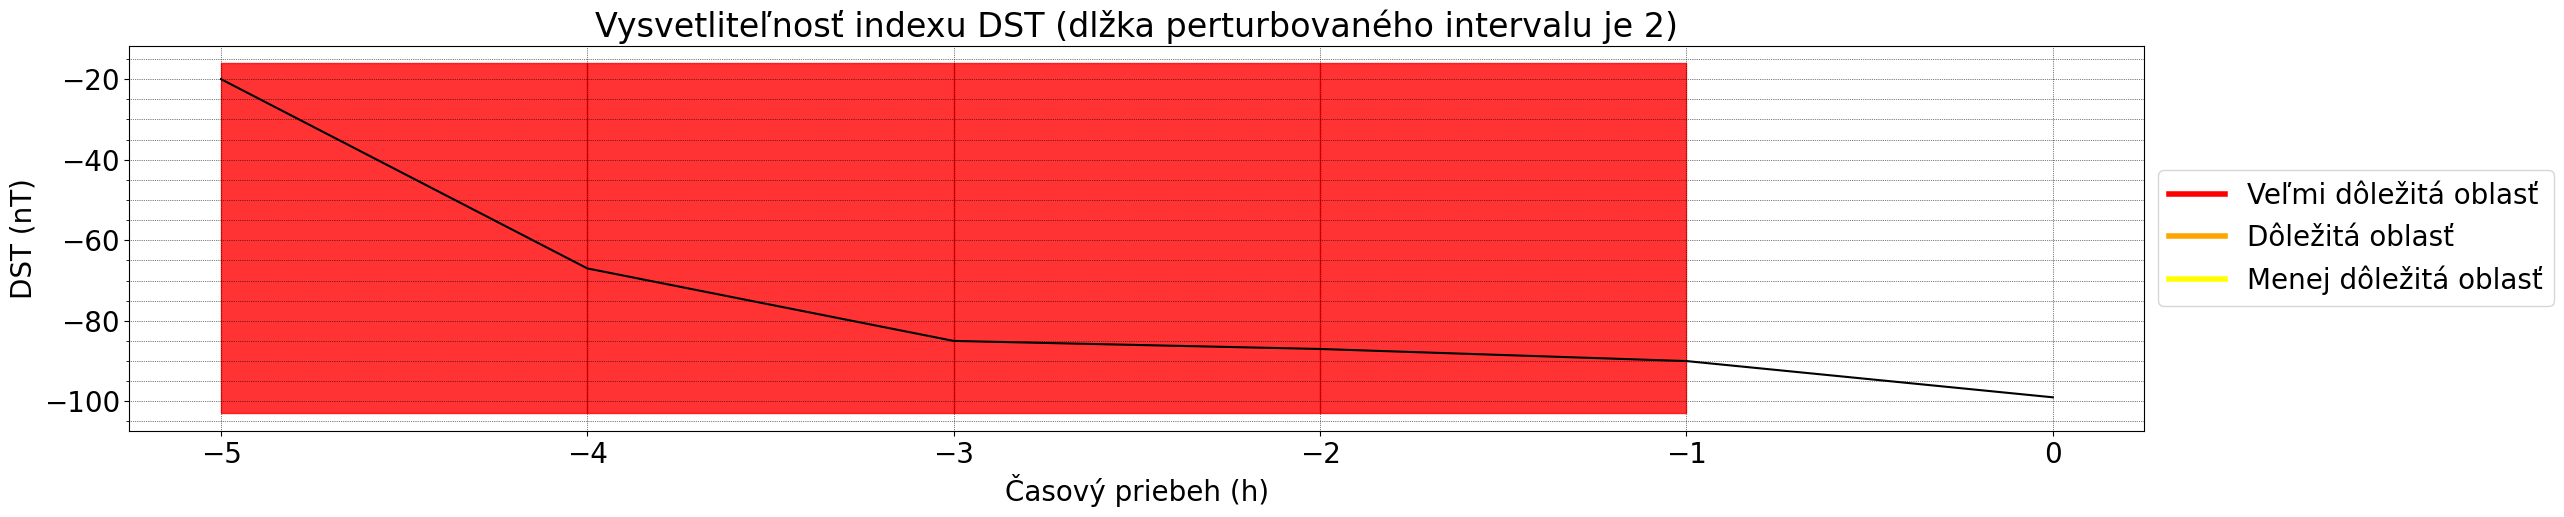

In [22]:
XAI_for_DST_Prediction(test_generator[0][0][24], model,2, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


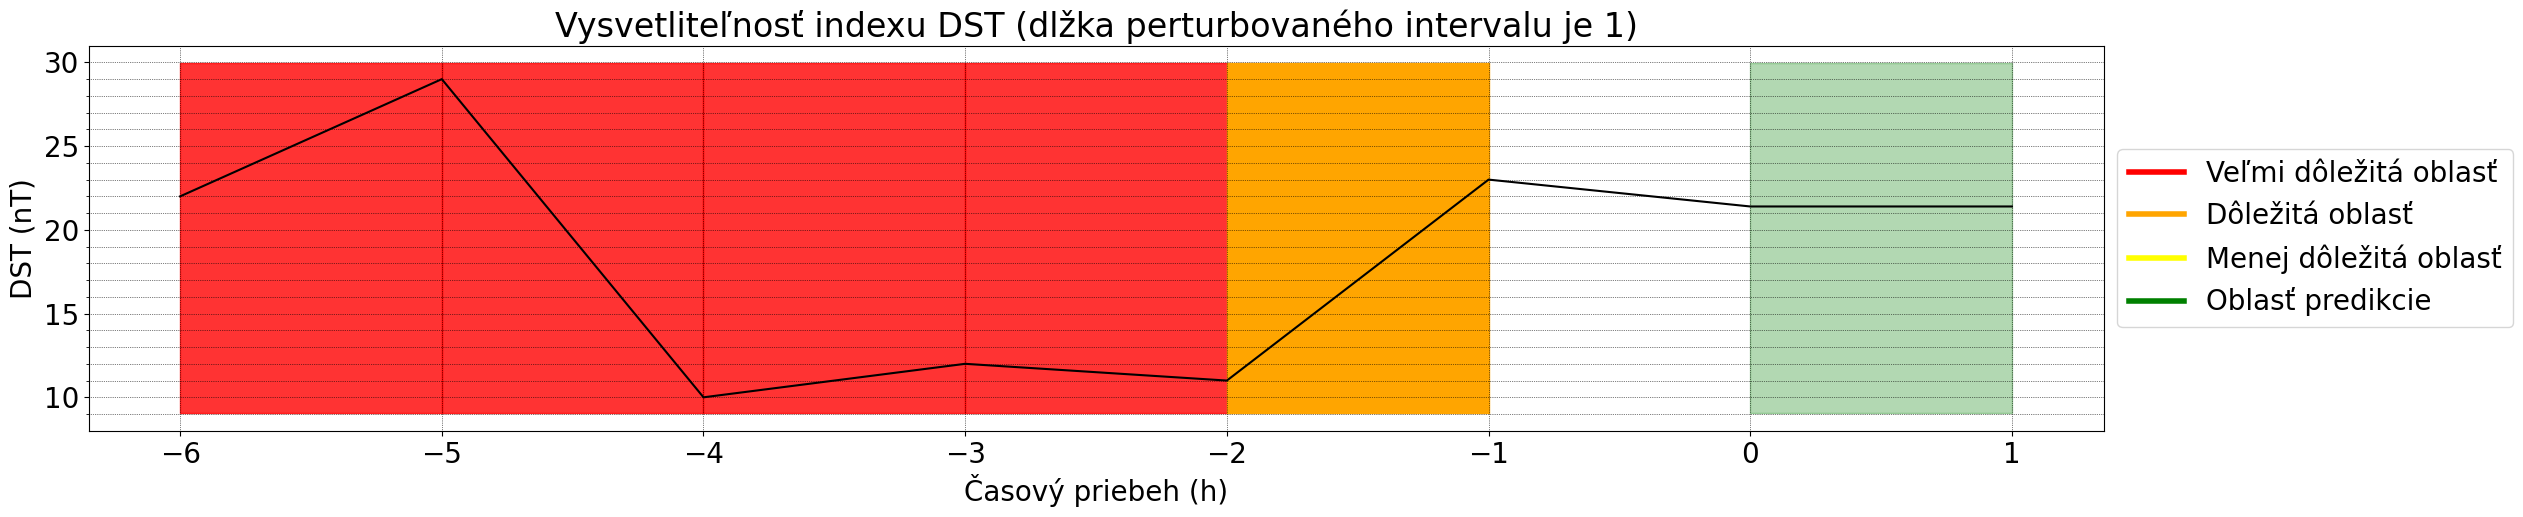

In [55]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][16], model,1, value_for_shutdown)

1/1 [==============================] - 0s 22ms/step


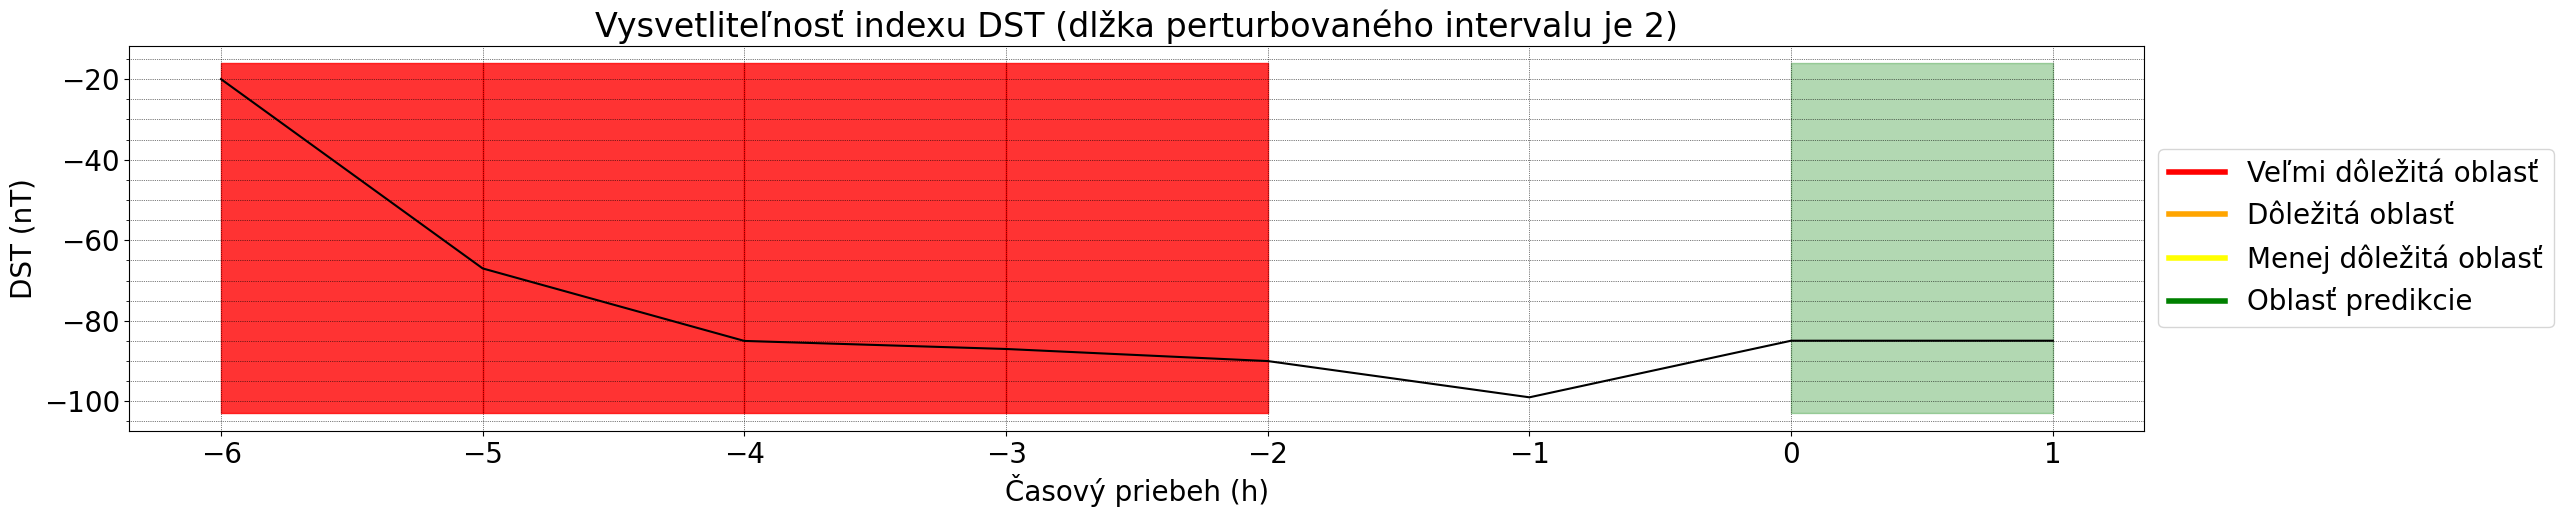

In [24]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][24], model,2, value_for_shutdown)

1/1 [==============================] - 0s 22ms/step


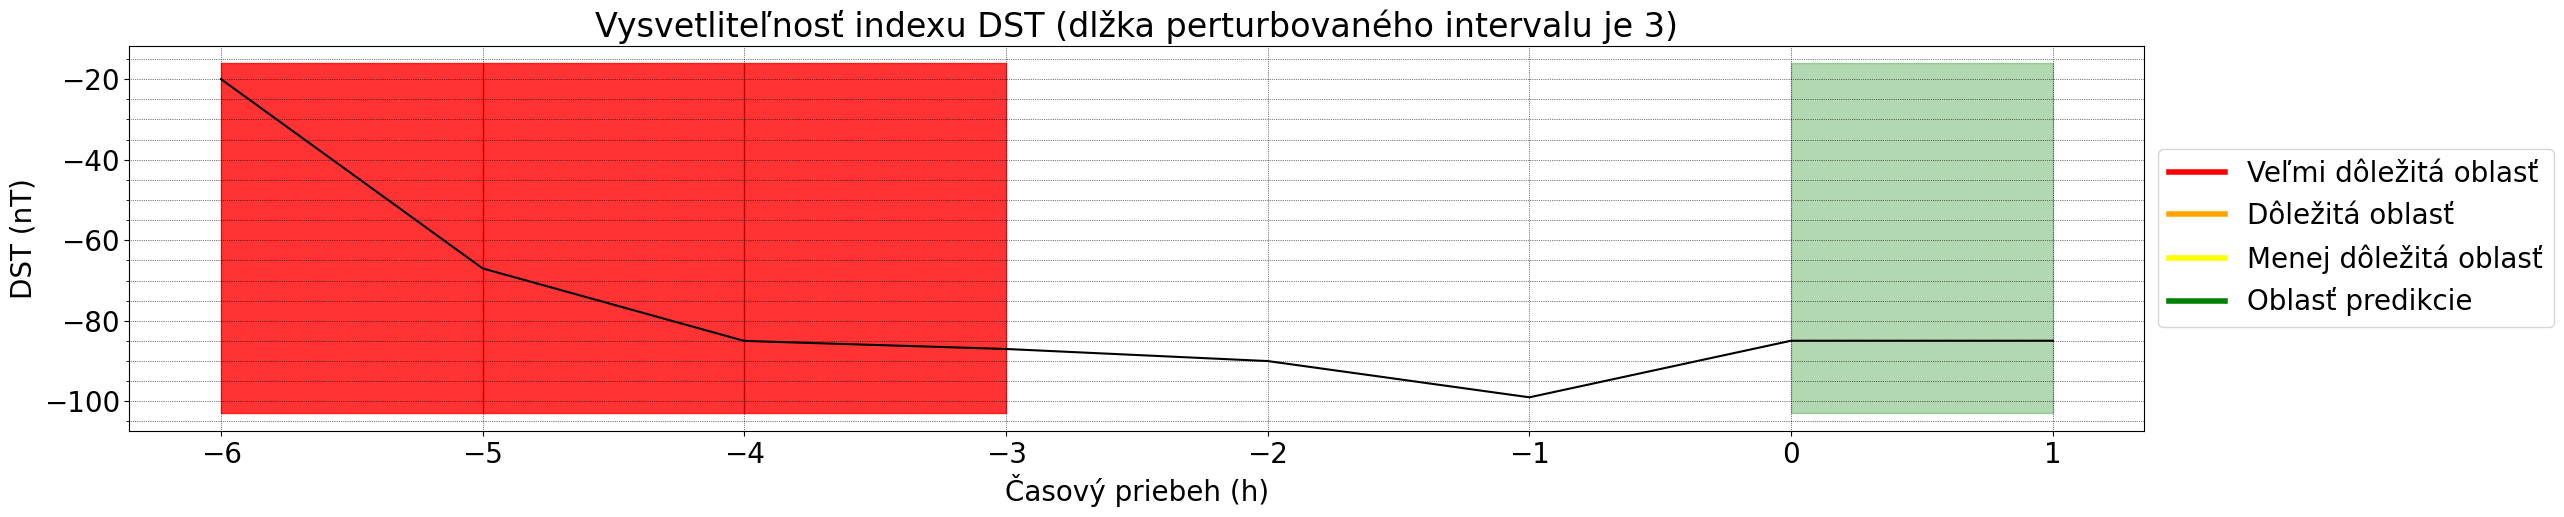

In [25]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][24], model,3, value_for_shutdown)

1/1 [==============================] - 0s 21ms/step


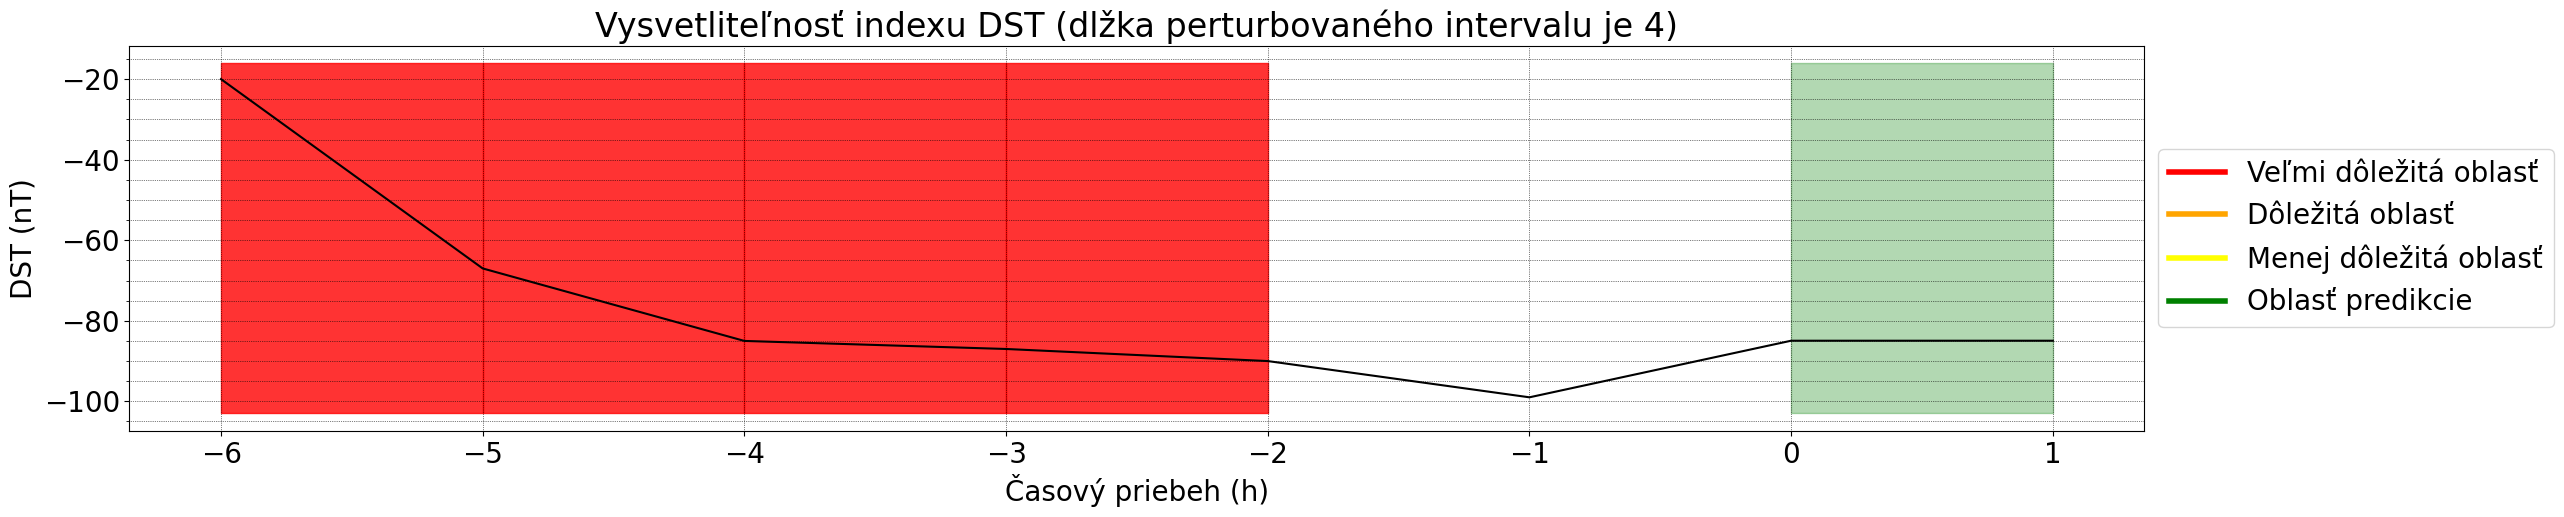

In [26]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][24], model,4, value_for_shutdown)

1/1 [==============================] - 0s 18ms/step


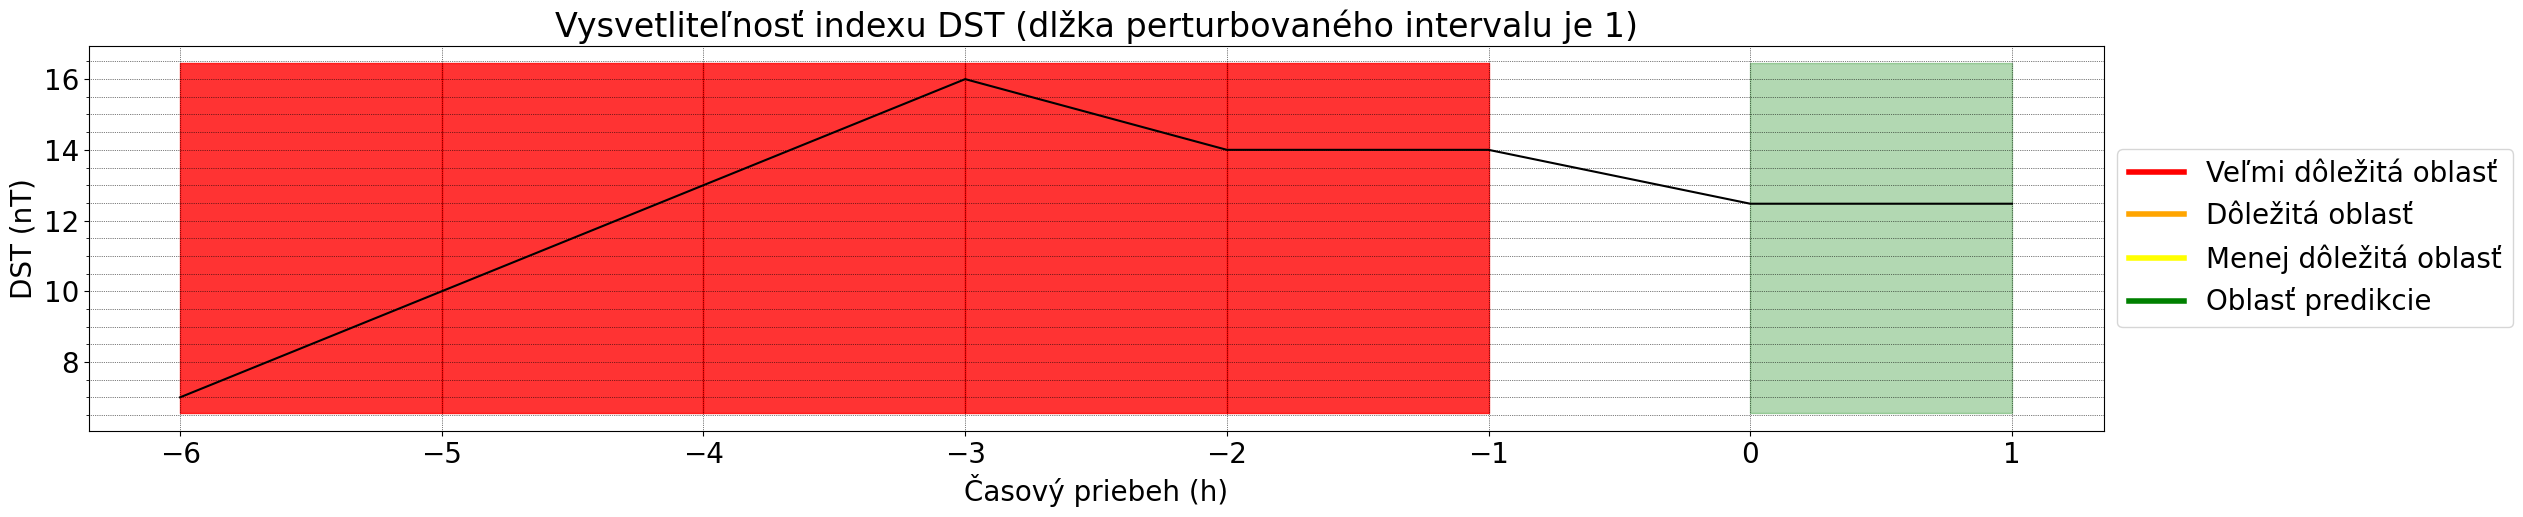

In [57]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][0], model,1, value_for_shutdown)

In [27]:
def XAI_for_DST_Prediction_with_predicted_value_for_dashboard(data_instance,data_instance2, model, interval_length, value_for_shutdown,max_range):
    testovacia_vzorka = data_instance.reshape(1,6,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
    
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]

    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    
    # Vizualizácia
    if np.any(data_instance2 != 0):
        dst = data_instance
        dst_new = np.append(dst,data_instance2[-1])
        dst_new = np.append(dst_new,data_instance2[-1])
    else:
        dst = data_instance
        dst_new = np.append(dst,y_pred_single)
        dst_new = np.append(dst_new,y_pred_single)

    time_data = np.arange(8)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:8],color='black')
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(max_range - 7, max_range+1, 1) % 24
    ax.set_xticks(grid_x_ticks , minor=True)
    ax.set_xticklabels(grid_x_ticks)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    if np.any(data_instance2 != 0):
        ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Skutočná oblasť'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    else:
        ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)
            
    #plt.axvline(x=6, color='green', linestyle='-', lw=5)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:7] > 0.85) & (audio_scaled1[0:7] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:7] > 0.6) & (audio_scaled1[0:7] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:7] > 0.5) & (audio_scaled1[0:7] <= 0.6), color='yellow', alpha=0.3)
    #plt.fill_between(time_data, ymin, ymax, where=(time_data >= time_data[-2]) & (time_data <= time_data[-1]), color='green', alpha=0.3)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6]+1, color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

# Dashboard zobrazuje reálne a predikované hodnoty DST a taktiež doležitosť intervalov pre pre predikciu novej hodnoty

In [28]:
import ipywidgets as widgets
from ipywidgets import IntSlider, Layout
from IPython.display import display, clear_output
from IPython.display import display, HTML
import datetime

In [29]:
# pred spustením je potrebné postupne spustiť kazdý riadok, trénovanie modelu nie je nutné, stači model načíatať

In [45]:
dashboard_title = widgets.HTML(value="<h1 style='color: green; text-align: left;'>Vysetliteľnosť modelu pre predikciu indexu DST</h1>")
style_html = """
<style>
    .widget-label { font-size: 16px; }
</style>
"""

sequences = []
for x, y in test_generator:
    sequences.extend(x)
    
y_pred = model.predict(test_generator)
    
style = {'description_width': 'initial'}

start_date_widget = widgets.DatePicker(
    description='Zvoľ si dátum sledovania:',
    disabled=False,
    style=style,
    value=datetime.date(2004, 7, 22),
    min=datetime.date(2004, 7, 22),
    max=datetime.date(2022, 5, 14)
)
hours_to_watch_widget = widgets.IntSlider(value=12, min=0, max=24, description='Koľko hodín chceš sledovať:', step=1, style=style)
hours_to_watch_widget.layout = Layout(width='350px', height='40px')
interval_length_widget = widgets.RadioButtons(options=[1, 2, 3],description='Výber dĺžky perturbovaného intervalu:',value=2,disabled=False, style=style)
index_widget = widgets.IntSlider(value=12,description='Výber konkrétnej hodiny počas dňa:', continuous_update=False,min=0,max=24, style=style)        
index_widget.layout = Layout(width='400px', height='40px')

generate_button1 = widgets.Button(description='Generovať graf', button_style='success')
generate_button2 = widgets.Button(description='Generovať graf', button_style='success')

output_container1 = widgets.Output()
output_container2 = widgets.Output()

def on_generate_button_clicked1(b):
    
    selected_date = start_date_widget.value
    start_index = (selected_date - datetime.date(2004, 7, 22)).days    
    start_index = max(0, start_index) 
    index = index_widget.value
    interval_length = interval_length_widget.value
    hours_to_watch = hours_to_watch_widget.value
    
    if start_index == 0:
        start_index = start_index*24
        fig1 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index-3],0, model, interval_length, value_for_shutdown,index)
        fig1.suptitle('Vybrané časové okno s predikovanou hodnotou',fontsize = 24)
        fig2 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index-3],sequences[start_index+index-3+1], model, interval_length, value_for_shutdown,index)
        fig2.suptitle('Vybrané časové okno so skutočnou hodnotou', fontsize = 24)
    else:
        start_index = (start_index*24)-3
        fig1 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index],0, model, interval_length, value_for_shutdown,index)
        fig1.suptitle('Vybrané časové okno s predikovanou hodnotou', fontsize = 24)
        fig2 = XAI_for_DST_Prediction_with_predicted_value_for_dashboard(sequences[start_index+index],sequences[start_index+index+1], model, interval_length, value_for_shutdown,index)
        fig2.suptitle('Vybrané časové okno so skutočnou hodnotou', fontsize = 24)
    
    with output_container1:
        clear_output(wait=True)
        display(fig2)
        display(fig1)
        
def on_generate_button_clicked2(b):

    selected_date = start_date_widget.value
    start_index = (selected_date - datetime.date(2004, 7, 22)).days    
    start_index = max(0, start_index) 
    hours_to_watch = hours_to_watch_widget.value
    last_elements = []
    elements = []
    start_index2 = 0
    start_index1 = 0
    hours_to_watch1 = hours_to_watch
    hours_to_watch2 = hours_to_watch
    
    if start_index == 0:
        hours_to_watch1 = 22
        start_index1 = 1
    elif start_index == 6504:
        start_index1 = (start_index*24)-2
        hours_to_watch1 = 16
    else:
        start_index1 = (start_index*24)-2
    
    for i in range(start_index1,start_index1+hours_to_watch1):
        last_elements.append(sequences[i][-1])

    fig3 = plt.figure(figsize=(26, 3))
    if start_index == 0:
        plt.plot(range(3, 3 + len(last_elements)), last_elements, marker='o', c='green')
        plt.xticks(range(3, 3 + hours_to_watch1))
    else:
        plt.plot(last_elements, marker='o', c='green')
        plt.xticks(range(hours_to_watch1)) 
        
    plt.title('Skutošné hodnoty DST na ' + str(hours_to_watch1) + "-hodinovom okne",fontsize=25)
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.yticks(fontsize=15)
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    
    if start_index == 0:
        start_index2 = 0
        hours_to_watch2 = 22
    elif start_index == 6504:
        start_index2 = (start_index*24)-3
        hours_to_watch2 = 17
    else:
        start_index2 = (start_index*24)-3
    
    for i in range(start_index2,start_index2+hours_to_watch2):
        elements.append(y_pred[i])
    
    fig4 = plt.figure(figsize=(26, 3))
    if start_index == 0:
        plt.plot(range(3, 3 + len(elements)), elements, marker='o', c='green')
        plt.xticks(range(3, 3 + hours_to_watch2))
    else:
        plt.plot(elements, marker='o', c='green')
        plt.xticks(range(hours_to_watch2))
    
    plt.title('Predikované hodnoty DST na '+ str(hours_to_watch2)+ "-hodinovom okne", fontsize=25)
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.yticks(fontsize=15)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    
    with output_container2:
        clear_output(wait=True)
        display(fig4)
        display(fig3)

generate_button1.on_click(on_generate_button_clicked1)
generate_button2.on_click(on_generate_button_clicked2)

display(HTML(style_html), dashboard_title, start_date_widget, hours_to_watch_widget, generate_button2, output_container2, index_widget,interval_length_widget,generate_button1,output_container1)


610/610 [==============================] - 8s 13ms/step


HTML(value="<h1 style='color: green; text-align: left;'>Vysetliteľnosť modelu pre predikciu indexu DST</h1>")

DatePicker(value=datetime.date(2004, 7, 22), description='Zvoľ si dátum sledovania:', max=datetime.date(2022, …

IntSlider(value=12, description='Koľko hodín chceš sledovať:', layout=Layout(height='40px', width='350px'), ma…

Button(button_style='success', description='Generovať graf', style=ButtonStyle())

Output()

IntSlider(value=12, continuous_update=False, description='Výber konkrétnej hodiny počas dňa:', layout=Layout(h…

RadioButtons(description='Výber dĺžky perturbovaného intervalu:', index=1, options=(1, 2, 3), style=Descriptio…

Button(button_style='success', description='Generovať graf', style=ButtonStyle())

Output()

# Dôležité dni kedy DST kleslo pod hodnotu -150

In [31]:
important_dates = []

for index, row in df.iterrows():
    if row['y_true'] < -150:
        date = pd.to_datetime(row['time']).date()
        important_dates.append(date)

important_dates = list(set(important_dates))

print(important_dates)

[datetime.date(2006, 12, 15), datetime.date(2004, 7, 27), datetime.date(2015, 3, 17), datetime.date(2004, 11, 8), datetime.date(2015, 3, 18), datetime.date(2005, 8, 24), datetime.date(2015, 12, 21), datetime.date(2015, 12, 20), datetime.date(2005, 5, 15), datetime.date(2018, 8, 26), datetime.date(2004, 11, 10), datetime.date(2004, 11, 9), datetime.date(2015, 6, 23)]


In [46]:
len(test)

156116

# Analýza 

In [32]:
sequence = []
for x, y in test_generator:
    sequence.extend(x)

In [33]:
len(sequence)

156110

In [34]:
before_2012 = df[df['time'].dt.year < 2012]
after_2017 = df[df['time'].dt.year <= 2017]

count1 = before_2012.shape[0]
count2 = after_2017.shape[0]
count1


65253

In [37]:
count2

117861

In [36]:
for i in range(65254, 117861):
    if abs(sequence[i][5] - sequence[i][0]) >= 50:
        # Zistí, či sekvencia obsahuje prvky na oboch stranách -20
        above = any(x >= -20 for x in sequence[i])
        below = any(x < -20 for x in sequence[i])
        if above and below:
            print(sequence[i])

[ -7.  -9. -32. -50. -55. -63.]
[ -9. -32. -50. -55. -63. -70.]
[  9.   0. -12. -25. -44. -41.]
[ -5. -13. -30. -38. -48. -59.]
[-13. -30. -38. -48. -59. -63.]
[ 12.   1.  -3. -11. -29. -38.]
[ -3. -11. -29. -38. -35. -57.]
[-17. -21. -20. -19. -47. -83.]
[-21. -20. -19. -47. -83. -86.]
[-20. -19. -47. -83. -86. -84.]
[-19. -47. -83. -86. -84. -88.]
[-35. -35. -35. -33. -27.  22.]
[-35. -35. -33. -27.  22.  15.]
[ 22.  15.   0. -16. -33. -40.]
[ 15.   0. -16. -33. -40. -44.]
[-20. -17. -34. -52. -68. -79.]
[-17. -34. -52. -68. -79. -87.]
[  1.   1.   0. -10. -33. -52.]
[  1.   0. -10. -33. -52. -74.]
[  0. -10. -33. -52. -74. -92.]
[ -10.  -33.  -52.  -74.  -92. -106.]
[ 28.  25.  20.  -1. -19. -28.]
[  3.  -2. -11. -18. -29. -49.]
[ -2. -11. -18. -29. -49. -71.]
[-11. -18. -29. -49. -71. -80.]
[-18. -29. -49. -71. -80. -86.]
[-12. -20. -36. -29. -37. -69.]
[-20. -36. -29. -37. -69. -98.]
[ 24.   5. -11. -20. -26. -31.]
[ 19.  13.  -3. -16. -28. -42.]
[ 13.  -3. -16. -28. -42. -43.]
[ 

In [38]:
import os

In [39]:
# vytvorenie pričinku ak neexistuje
image_direction1 = "grafy_analyza_perturb1_test_6_1"
os.makedirs(image_direction1, exist_ok=True)

In [40]:
# vytvorenie pričinku ak neexistuje
image_direction2 = "grafy_analyza_perturb2_test_6_1"
os.makedirs(image_direction2, exist_ok=True)

In [41]:
# vytvorenie pričinku ak neexistuje
image_direction3 = "grafy_analyza_perturb3_test_6_1"
os.makedirs(image_direction3, exist_ok=True)

In [44]:
for i in range(65254, 117861):
    if abs(sequence[i][5] - sequence[i][0]) >= 50:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])

        if over_the_border and below_the_border:
            fig = XAI_for_DST_Prediction_with_predicted_value(sequence[i], model, 3, value_for_shutdown)
            file_path = os.path.join(image_direction3, f"image_{i}.jpg") 
            fig.savefig(file_path, dpi=50, bbox_inches='tight') 
            #fig.savefig(file_path)
            plt.close(fig)

1/1 [==============================] - 0s 18ms/step
